### Par Youcef Benslimane, N°28715654

# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Useful functions 
def gaussianKernel(sigma):
    N = np.int(np.ceil(3*sigma))
    x = y = np.linspace(np.int(-3*sigma),np.int(3*sigma),2*N+1)
    X,Y = np.meshgrid(x,y)
    noyau = np.exp(-(X*X+Y*Y)/(2*sigma*sigma))
    return noyau/noyau.sum()

In [2]:
#Old functions

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def imagePad(I,n):
    image = I.copy()
    image = np.pad(image,n,'constant')
    return image

# The following function retrieves the spatial derivatives 
#Ix and Iy and The gradient norm from an Image I
# Used in TME 5
def SobelPartOne(I):
    sobelX = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    sobelY = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    horizontal = scipy.signal.convolve2d(I,sobelX, mode='same')
    vertical = scipy.signal.convolve2d(I,sobelY, mode='same')
    
    #Compute the gradient
    gradient = np.sqrt(horizontal**2 + vertical**2)
    
    return horizontal, vertical, gradient

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [3]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    #Step 1
    Ix, Iy, grad = SobelPartOne(image)
   
    #Step 2
    Ix2 = Ix**2
    Iy2 = Iy**2
    IxIy = Ix*Iy
    
    #Step 3
    sigma = (scale - 1)/6
    
    gaussian_N = gaussianKernel(sigma)
    convolved_Ix2 = scipy.signal.convolve2d(Ix2, gaussian_N, mode = 'same')
    convolved_Iy2 = scipy.signal.convolve2d(Iy2, gaussian_N, mode = 'same')
    convolved_IxIy= scipy.signal.convolve2d(IxIy, gaussian_N, mode = 'same')
    
    #Step 4
    det_M = convolved_Ix2 * convolved_Iy2 - convolved_IxIy**2 # det = ad - bc
    trace_M = convolved_Ix2 + convolved_Iy2 # trace = a + d
    
    #Step 5
    R = det_M - kappa * trace_M**2
    
    return R
    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

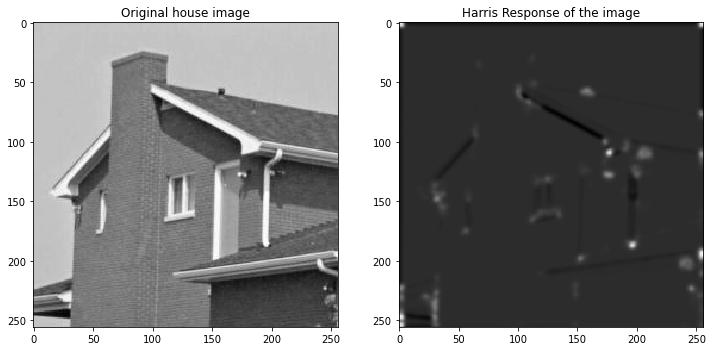

In [4]:
house2 = np.array(Image.open('img/house2.png'))

house2_HR = computeR(house2, 15, 0.04)

niceDisplay14([house2, house2_HR],
              ['Original house image', 'Harris Response of the image'])

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

The Harris detector just maps a non-significant value onto homogenous areas, whereas edges are shown with a negative hue. The most important data are the corner locations, that are punctually emphasized in white.  
It is worth mentioning the outliers that loom on the corners of the display field. These are linked to the zero-padding policy used to convolve the filters with the original image. The strong gradients between the artificial null values and the sky's light surface are misinterpreted as additional edges around the display field, and Harris' algorithm states that edge intersections shall always be recognised as corners.  
But it's also worth to notice that no false detections were made apart from that.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [5]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    Rb = np.where(R>thres, 1, 0)
    return Rb
    

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [6]:
def rnms(R,Rbin):
    R_LocMax = np.zeros(R.shape)
    padded_R = imagePad(R, 1)
    
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if Rbin[i,j] == 1 and R[i,j] > np.max([padded_R[i,j+1],padded_R[i+2,j+1],padded_R[i+1,j],padded_R[i+1,j+2]]):
                    R_LocMax[i,j] = 1
    return R_LocMax
    

In [7]:
def rnms_with_roll(R, Rbin):
    R_LocMax = np.zeros(R.shape)
    
    # computing 1-px shifts in all four directions
    R_bottom = np.roll(R,1,axis=0)
    R_top = np.roll(R,-1,axis=0)
    R_left = np.roll(R,1,axis=1)
    R_right = np.roll(R,-1,axis=1)
    
    # generating True-False matrices
    Mb = R>R_bottom
    Mt = R>R_top
    Ml = R>R_left
    Mr = R>R_right
    Mbin = Rbin==1
    
    M = Mb & Mt & Ml & Mr & Mbin
    R_LocMax = np.where(M==True, 1, 0)
    
    return R_LocMax

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [8]:
def cornerDetector(image, sigma, kappa, thres):
    R = computeR(image,sigma,0.04)
    Rbin = thresholdR(R, thres)
    #R_LocMax = rnms(R,Rbin)
    R_LocMax = rnms_with_roll(R, Rbin)
    
    return R_LocMax

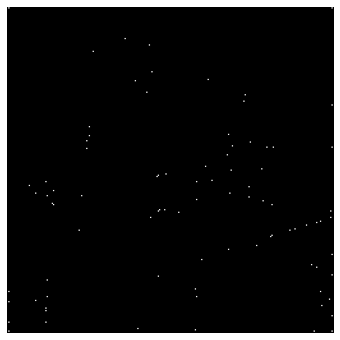

In [9]:
#house2Corner = cornerDetector(house2, 10, 0.04, 10e8)
#house2Corner = cornerDetector(house2, 15, 0.04, 10e8)
#house2Corner = cornerDetector(house2, 15, 0.04, 10e7)
house2Corner = cornerDetector(house2, 15, 0.04, 10e6)
imshow(house2Corner)

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

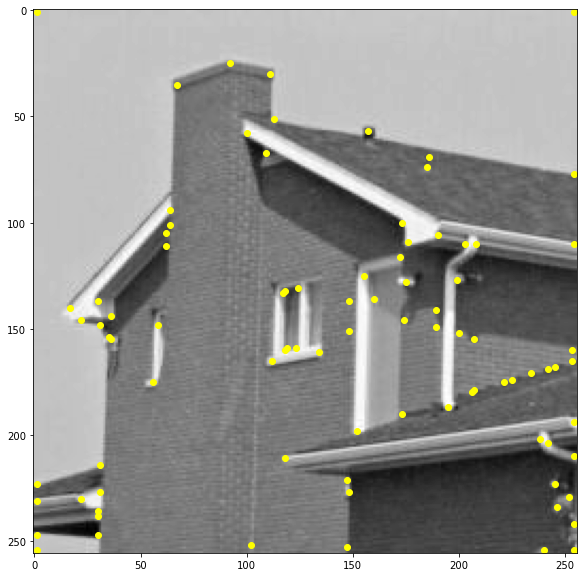

In [10]:
y,x = np.nonzero(house2Corner)
plt.figure(figsize = (10,10))
plt.imshow(house2)
plt.scatter(x, y, c='yellow')
plt.show()

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

To find good values for Sigma and Threshold, We tried different values for both and narrowed it down to $\sigma$ = 2.1 and Threshold = $10^6$ as they seemed to be the values that give the best results. 

We noticed that higher threshold values than $10^6$ made the detector less precise ( data loss ), and lower threshold values gave us false detections.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

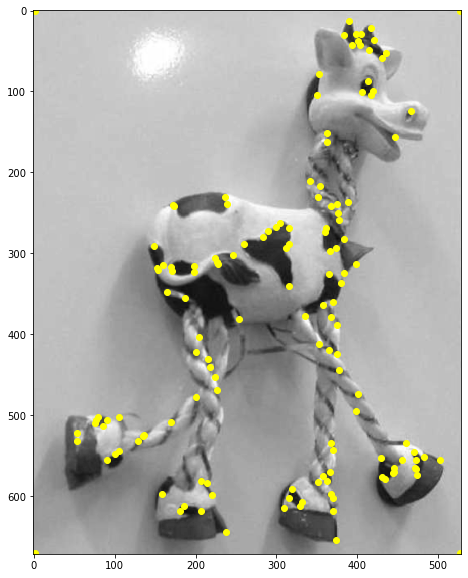

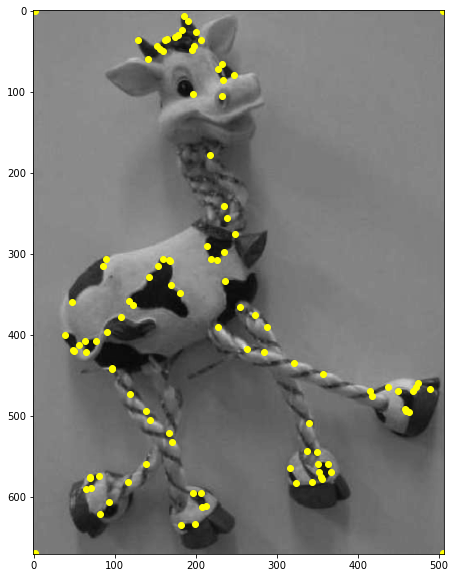

In [23]:
toyHorse1 = np.array(Image.open('img/toyHorse1.png'))
toyHorse1corner = cornerDetector(toyHorse1,15,0.04,1e8)

y,x = np.nonzero(toyHorse1corner)
plt.figure(figsize = (10,10))
plt.imshow(toyHorse1)
plt.scatter(x, y, c='yellow')
plt.show()

toyHorse2 = np.array(Image.open('img/toyHorse2.png'))
toyHorse2corner = cornerDetector(toyHorse2,15,0.04,5e7)

y,x = np.nonzero(toyHorse2corner)
plt.figure(figsize = (10,10))
plt.imshow(toyHorse2)
plt.scatter(x, y, c='yellow')
plt.show()

2) What are the dynamic ranges of these two images ?

In [12]:
toyHorse1_range = np.amax(toyHorse1)-np.amin(toyHorse1)
toyHorse2_range = np.amax(toyHorse2)-np.amin(toyHorse2)

print('The dynamic range of ToyHorse1 : ', toyHorse1_range)
print('The dynamic range of ToyHorse2 : ', toyHorse2_range)

The dynamic range of ToyHorse1 :  254
The dynamic range of ToyHorse2 :  253


3) What are the transformations beetween the two images ?

Rotation! 
In the second image, the object is rotated. We also notice that there is a difference in brightness.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

As seen during the lecture and the tutorial work, theoretically, Harris Corner Detector is invariant to rotation. 
These two images (ToyHorse 1&2) do not prove the contrary since we haven't rotated the actual image but the object in real life. In other terms, there is no way that we could obtain ToyHorse1 from ToyHorse2 (and vice-versa).
So in conclusion, this experiment doesn't prove or not that the detection is invariant to rotation.

However, we notice that the detection is better in the first image due to it being brighter! More brightness = Edges are sharper.

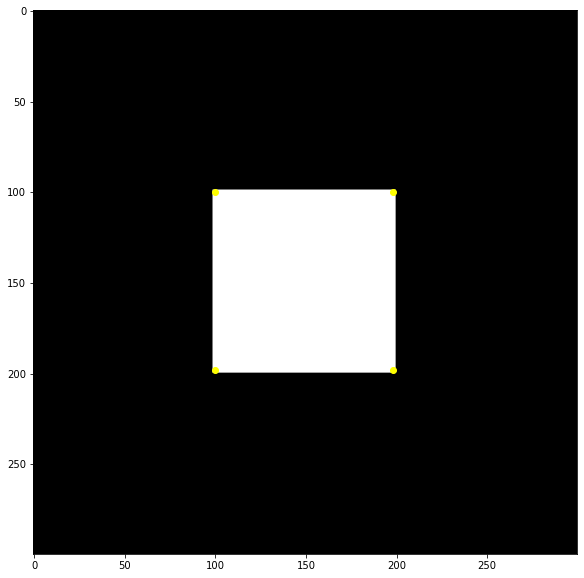

In [26]:
#more experiments
#Rectangle image
rectangle = np.array(Image.open('img/rectangle.png'))
rectanglecorner = cornerDetector(rectangle,15,0.04,1e7)

y,x = np.nonzero(rectanglecorner)
plt.figure(figsize = (10,10))
plt.imshow(rectangle)
plt.scatter(x, y, c='yellow')
plt.show()

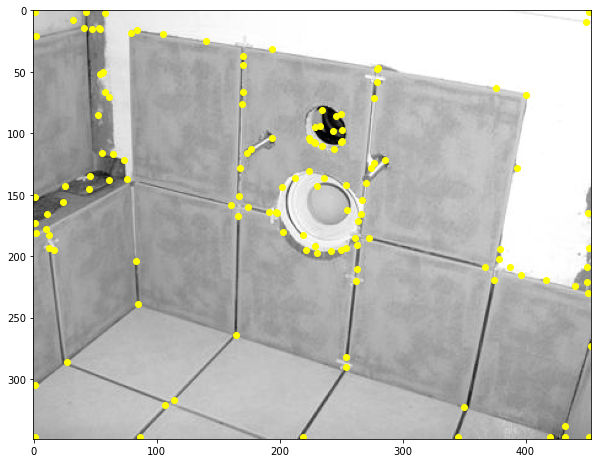

In [29]:
#carrelage_wikipedia image
carrelage = np.array(Image.open('img/carrelage_wikipedia.jpg'))
carrelagecorner = cornerDetector(carrelage,15,0.04,1e7)

y,x = np.nonzero(carrelagecorner)
plt.figure(figsize = (10,10))
plt.imshow(carrelage)
plt.scatter(x, y, c='yellow')
plt.show()

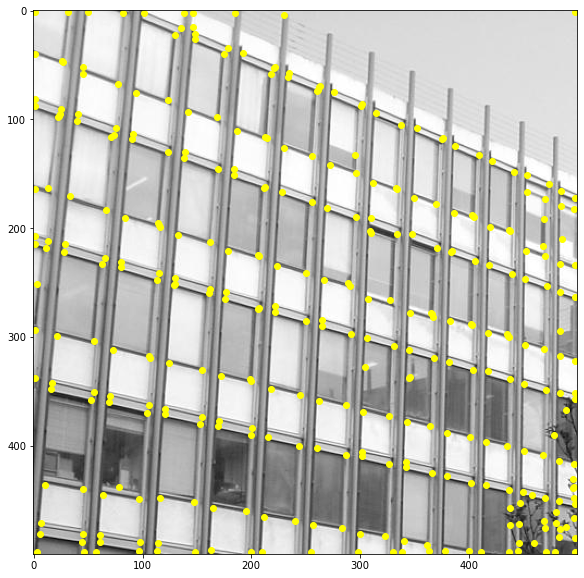

In [31]:
#Jussieu_wikipedia image
jussieu = np.array(Image.open('img/Jussieu_wikipedia.jpg'))
jussieucorner = cornerDetector(jussieu,15,0.04,2e8)

y,x = np.nonzero(jussieucorner)
plt.figure(figsize = (10,10))
plt.imshow(jussieu)
plt.scatter(x, y, c='yellow')
plt.show()

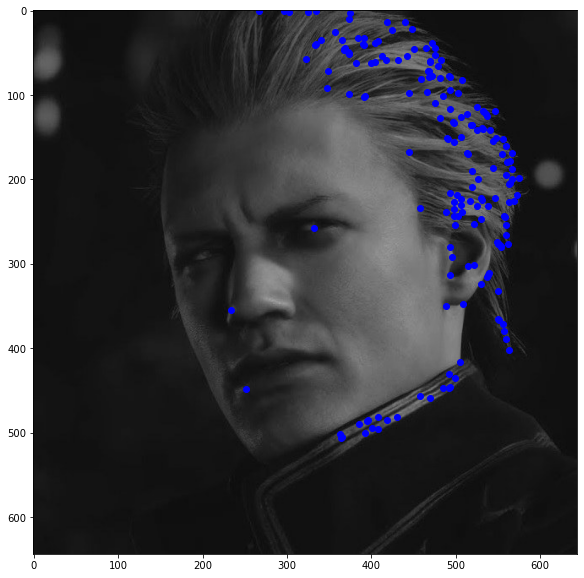

In [34]:
#Vergil image
vergil = np.array(Image.open('img/vergil.png'))

vergilcorner = cornerDetector(vergil[:,:,1],15,0.04,5e6)

y,x = np.nonzero(vergilcorner)
plt.figure(figsize = (10,10))
plt.imshow(vergil)
plt.scatter(x, y, c='blue')
plt.show()